In [1]:
%matplotlib inline
import pywt                     # sudo pip3 install pywavelets
import matplotlib.pyplot as plt # sudo apt-get install python3-matplotlib
import numpy as np              # sudo apt-get install python3-numpy
import math
from skimage import color, io

In [2]:
lenna = io.imread("images/lenna.png")
lenna = color.rgb2lab(lenna)

In [29]:
{"L": {"min": lenna[:,:,0].reshape((1,512*512)).min(), "max": lenna[:,:,0].reshape((1,512*512)).max()},
"a": {"min": lenna[:,:,1].reshape((1,512*512)).min(), "max": lenna[:,:,1].reshape((1,512*512)).max()},
"b": {"min": lenna[:,:,2].reshape((1,512*512)).min(), "max": lenna[:,:,2].reshape((1,512*512)).max()}}

{'L': {'max': 97.024352894762998, 'min': 10.49294988765244},
 'a': {'max': 60.9386412620333, 'min': -5.1307919511107691},
 'b': {'max': 81.960463801678358, 'min': -37.608425385578613}}

In [4]:
lenna.shape

(512, 512, 3)

In [30]:
lennaGray = (lenna[:,:,1] + lenna[:,:,2]) / 2

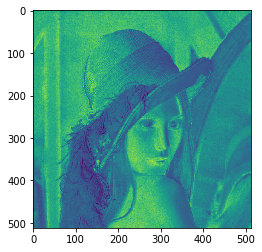

In [46]:
plt.imshow(lennaGray)

In [32]:
coeffs = pywt.dwt2(lennaGray,'haar')

In [33]:
cA, (cH, cV, cD) = coeffs

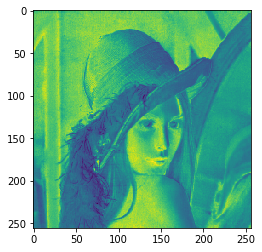

In [34]:
plt.imshow(cA)

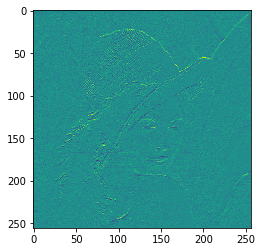

In [35]:
plt.imshow(cH)

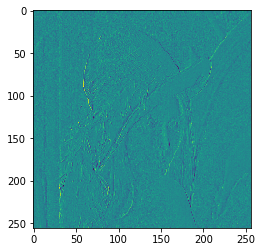

In [36]:
plt.imshow(cV)

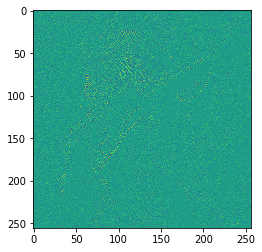

In [37]:
plt.imshow(cD)

In [64]:
def pixelDiff(image, ay, ax, by, bx, threshold):
    height = image.shape[0]
    width = image.shape[1]
    
    a = image[ay, ax]
    b = image[by, bx]
    return np.sum((a-b)**2) <= threshold**2

In [65]:
def discoverRegion(image, raster, yseed, xseed, threshold):
    assert(raster[yseed, xseed] == -1)
    region = np.max(raster) + 1
    queue = [(yseed, xseed)]
    raster[yseed,xseed] = region

    while len(queue) > 0:
        (y,x) = queue.pop(0)
        
        for (p,q) in [(y-1,x),(y+1,x),(y,x-1),(y,x+1)]:
            if raster[p,q] == -1 and pixelDiff(image, y, x, p, q, threshold):
                raster[p,q] = region
                queue.append((p,q))        

In [66]:
def fullRegionGrow(image, threshold):
    height = image.shape[0]
    width = image.shape[1]
    raster = np.zeros((height, width))-1
    
    # Write a board of -2 around the image.
    for y in range(height):
        raster[y,width-1] = -2
        raster[y,0] = -2
    for x in range(width):
        raster[height-1,x] = -2
        raster[0,x] = -2

    # Begin 
    for y in range(height):
        for x in range(width):
            if raster[y,x] == -1:
                discoverRegion(image, raster, y, x, threshold)
    return raster

In [71]:
raster = fullRegionGrow(lenna[:,:,1:2], 2)

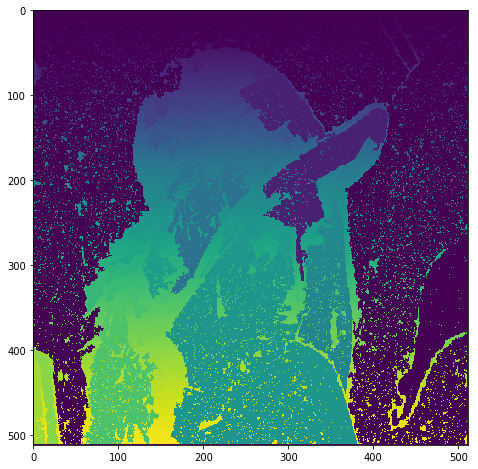

In [72]:
plt.figure(figsize=(8,8))
plt.imshow(raster)

In [18]:
def isSkinTone(pixel, redblue, greenblue, threshold=0.05):
    redEstimate = pixel[2] * redblue
    greenEstimate = pixel[2] * greenblue
    redError = math.fabs(pixel[0] - redEstimate)/redEstimate
    greenError = math.fabs(pixel[1] - greenEstimate)/greenEstimate

    return redError <= threshold and greenError <= threshold

In [20]:
def getSkinRaster(image, threshold=0.05):
    (height, width, numslots) = image.shape
    raster = np.zeros((height, width))

    # Begin 
    for y in range(height):
        for x in range(width):
            if isSkinTone(image[y,x], threshold):
                raster[y,x] = 1
    return raster

In [21]:
skinraster = getSkinRaster(lenna, 0.1)

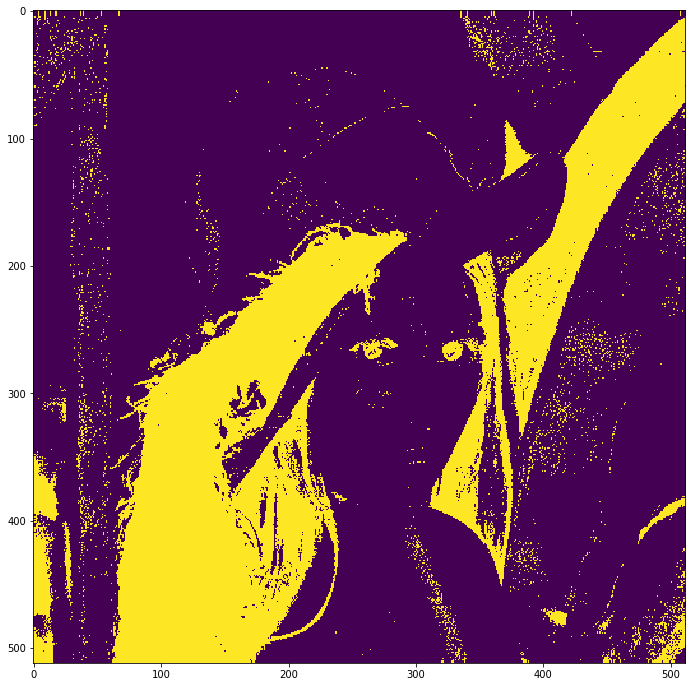

In [22]:
plt.figure(figsize=(12,12))
plt.imshow(skinraster)